In [ ]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter
from scipy.optimize import curve_fit
#import the functions from functions.py
import functions
from functions import *

import importlib

In [ ]:
#define the variables that determine how many photons are released
recordTime = .003*0+60*10**-3  #s
rateSingleAtom = 145000*0+10*10**3  #Hz
rateBackground = 10000*0+1*10**3  #Hz
lifetimeOfTrap =  0*10000+60*10**-3  #s
#up to this many photons
countEnd = 1000
xx = np.arange(countEnd)
#the background is just a poisson distribution
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
#get the distribution, the integrals take longer then the rest of the code
probDistSingle = singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)
#now convolve with background rate
probDistSingle = convolve(probDistBack,probDistSingle)
plt.plot(xx,probDistSingle)
plt.title("Probability distribution vs photon count for a single dipole trapped atom")
plt.xlabel("Photon count")
plt.ylabel("Probability")
plt.show()

In [ ]:
hist = getHistogram(probDistBack,probDistSingle,xx)
graph(hist,xx,p0=[1000, 50, 1, 400, 600, 5],fit = False)
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground))

The integration takes a long time, this is my attempt at simulating atom loss during a measurement many times. Instead of taking an integral for each photon count, take the probability of the atom leaving the trap at time t for t from 0 to recorded time. At each of the steps change the probability that the atom will leave, then count up the amount of photons according to the status of the atom at that step(rate/totalTimeSteps). I tried taking a new sample from each dist at each step but that only created two very distinct gaussian dist far apart. I think that is interesting and it might have something to do with normal distrbutions and sample numbers. 



* The problem I am having is the fact that the simulation is just a poission distribution, I need that exponential tail like that of the analytical function.

* The standard deviation gets smaller with more experiments, I think that shows that the way I am having that atoms leave the trap is not right.

* There needs to be photon count values that are not clustered around the mean, there should be atoms leaving the trap and only producing the background rate. Instead, they are just averaging out to the same values, the background rate just moves the median.



In [162]:
def simulateAtomLoss(recordTime,trapLifetime,xx,probDistSingle,probDistBack,totalTimeSteps = 100,experiments = 10000):
    """ 
    simulates an atom being lossed during readout with given trap paramaters 
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        trapLifetime: the lifetime of the trap(seconds)
        xx: an array of integers that are the possible photon counts to measure
        probDistBack: the background probability distribution
        probDistSingle: the single atom probability distribution
    Returns:
        an array of probability distribution for a single atom 
    """
    time_bins = np.linspace(0,recordTime,totalTimeSteps)
    #the dist of the atom in the trap 
    #normalize = 2*lifetimeOfTrap*np.exp(2*recordTime/trapLifetime)/(np.exp(2*recordTime/trapLifetime)-1)
    time_dist = [np.exp(-t/trapLifetime)/trapLifetime for t in time_bins]
    time_dist = time_dist/max(time_dist)
    mean = np.mean(time_bins)
    
    #so given each time step, there is a chance 1-time_dist[step] of leaving the trap
    #each step there is a poisson dist of photons emiited that is divided by nTimeSteps
    probDist = []
    atomLeft = False
    
   # dist = convolve(probDistSingle,probDistBack)
    for e in tqdm(range(experiments)):
        nPhotons = 0
        randomBack = choices(xx,probDistBack,k=totalTimeSteps)
        randomeSingle = choices(xx,probDistSingle,k=totalTimeSteps)
       # random = choices(xx,dist,k = totalTimeSteps)
        atomLeft = False
        for i,t in enumerate(time_dist):
            w = [1-t,t]
            #w = [mean,1]
            if not atomLeft and choices([False,True],weights=w)[0]:
                nPhotons = nPhotons + randomeSingle[i]
            else:
                atomleft = True
                nPhotons = nPhotons + randomBack[i]
        probDist.append(nPhotons/totalTimeSteps)


    return probDist

In [163]:
importlib.reload(functions)
test = poisson.pmf(xx,(rateSingleAtom)*recordTime)
probDistSimulated = simulateAtomLoss(recordTime,lifetimeOfTrap,xx,test,probDistBack)


100%|██████████| 10000/10000 [00:07<00:00, 1331.75it/s]


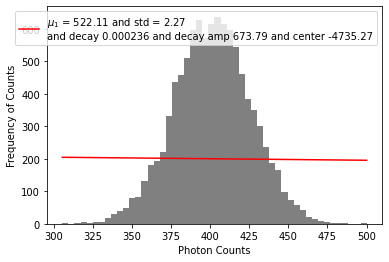

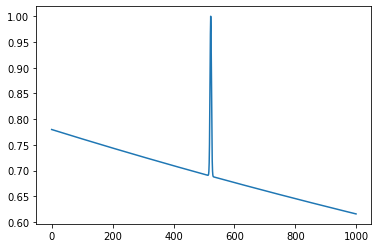

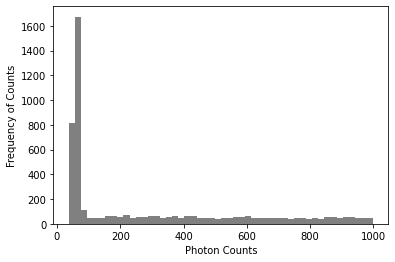

'plt.show()\nplt.plot(xx,probDistSingle)'

In [164]:
importlib.reload(functions)

fitValues = functions.graph(probDistSimulated,xx,p0 = [500,580,2,.01,.01,-1699],double = False,decay=True)
plt.plot(xx,fitValues/max(fitValues))
plt.show()
fitValues = convolve(probDistBack,fitValues/max(fitValues))

h = getHistogram(probDistBack,fitValues,xx)
graph(h,xx,fit = False)
"""plt.show()
plt.plot(xx,probDistSingle)"""